In [20]:
import pandas as pd
import numpy as np
import torch
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt


In [21]:
class FER2013Label(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        
        self.classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
        self.image_paths = []
        self.labels = []
        
        # Loop through subfolderas,
        for idx, emotion in enumerate(self.classes):
            emotion_dir = os.path.join(root_dir, emotion)
            for filename in os.listdir(emotion_dir):
                if filename.endswith('.jpg'):  
                    self.image_paths.append(os.path.join(emotion_dir, filename))
                    self.labels.append(idx)  

        self.dataset = pd.DataFrame({
            'image_paths': self.image_paths,
            'labels': self.labels
        })

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]
    
        if self.transform:
            image = self.transform(image)
        
        return image, label
transform_face = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))])
train_data = FER2013Label(root_dir=r'archive/train/', transform=transform_face)
test_data = FER2013Label(root_dir=r'archive/test/', transform=transform_face)

In [22]:
tensor = train_data[1][0]
print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([1, 48, 48])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


visualizing label assigment.

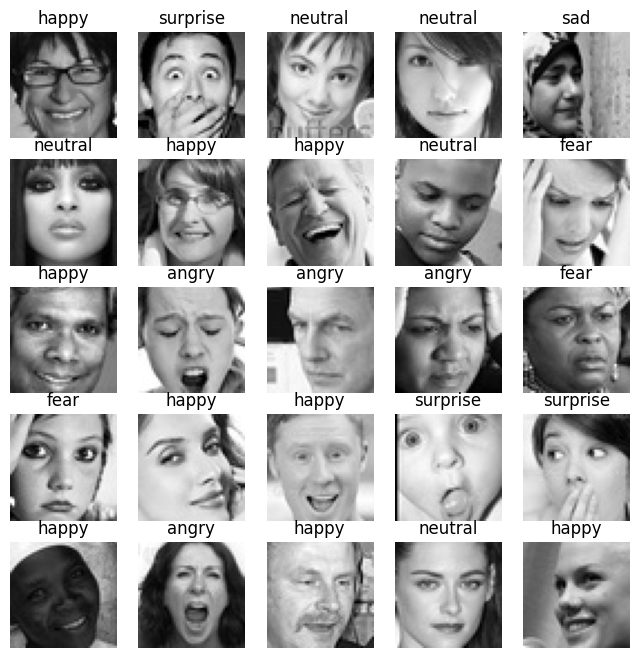

In [23]:

figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(train_data.classes[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [24]:

import torch.nn as nn
import torch.nn.functional as F


class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  
        self.pool1 = nn.MaxPool2d(2, 2)                          
    
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) 
        self.pool2 = nn.MaxPool2d(2, 2)                           
        self.dropout2 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)                          
        

        self.flattened_size = 64 * 6 * 6
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.dropout_fc = nn.Dropout(0.2)  # Standard dropout in fully connected

        self.output = nn.Linear(64, 7)  # 7 emotion classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
       

        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = x.view(-1, self.flattened_size) 
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)

        x = self.output(x)
        return x


In [25]:
model = EmotionCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [26]:
from tqdm import tqdm 

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)  

EPOCHS = 11
for epoch in range(EPOCHS):
    model.train()  

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # progress bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch")

    for images, labels in progress_bar:
        
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        progress_bar.set_postfix(loss=running_loss/len(train_loader), 
                                 accuracy=correct_predictions/total_predictions)

  
    avg_loss = running_loss / len(train_loader)
    avg_accuracy = correct_predictions / total_predictions
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}")


Epoch 1/11: 100%|██████████| 449/449 [00:57<00:00,  7.74batch/s, accuracy=0.324, loss=1.68] 


Epoch 1/11 - Loss: 1.6845, Accuracy: 0.3238


Epoch 2/11: 100%|██████████| 449/449 [00:53<00:00,  8.33batch/s, accuracy=0.433, loss=1.47] 


Epoch 2/11 - Loss: 1.4660, Accuracy: 0.4329


Epoch 3/11: 100%|██████████| 449/449 [00:53<00:00,  8.38batch/s, accuracy=0.471, loss=1.37] 


Epoch 3/11 - Loss: 1.3700, Accuracy: 0.4712


Epoch 4/11: 100%|██████████| 449/449 [00:56<00:00,  7.95batch/s, accuracy=0.504, loss=1.29] 


Epoch 4/11 - Loss: 1.2937, Accuracy: 0.5042


Epoch 5/11: 100%|██████████| 449/449 [00:55<00:00,  8.06batch/s, accuracy=0.522, loss=1.25] 


Epoch 5/11 - Loss: 1.2468, Accuracy: 0.5219


Epoch 6/11: 100%|██████████| 449/449 [01:01<00:00,  7.29batch/s, accuracy=0.535, loss=1.21] 


Epoch 6/11 - Loss: 1.2105, Accuracy: 0.5350


Epoch 7/11: 100%|██████████| 449/449 [00:58<00:00,  7.68batch/s, accuracy=0.551, loss=1.17] 


Epoch 7/11 - Loss: 1.1724, Accuracy: 0.5514


Epoch 8/11: 100%|██████████| 449/449 [01:00<00:00,  7.39batch/s, accuracy=0.562, loss=1.14] 


Epoch 8/11 - Loss: 1.1413, Accuracy: 0.5623


Epoch 9/11: 100%|██████████| 449/449 [01:05<00:00,  6.82batch/s, accuracy=0.57, loss=1.12]  


Epoch 9/11 - Loss: 1.1161, Accuracy: 0.5702


Epoch 10/11: 100%|██████████| 449/449 [00:56<00:00,  8.00batch/s, accuracy=0.583, loss=1.09] 


Epoch 10/11 - Loss: 1.0868, Accuracy: 0.5826


Epoch 11/11: 100%|██████████| 449/449 [00:55<00:00,  8.12batch/s, accuracy=0.59, loss=1.06]  

Epoch 11/11 - Loss: 1.0649, Accuracy: 0.5904


In [27]:
# Eval test data
model.eval()  
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
true_labels = []  
predicted_labels = []  


In [28]:
with torch.no_grad():
    for images, labels in test_loader:
        
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)  
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        #labels 
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# test summary
avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct_predictions / total_predictions
print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")



Test Loss: 1.1514, Test Accuracy: 0.5649


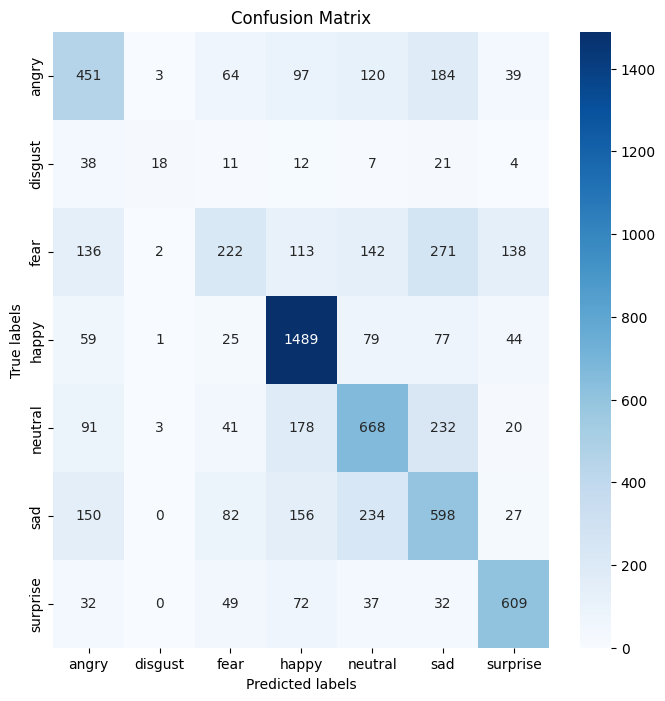

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


conf_mat = confusion_matrix(true_labels, predicted_labels)

# confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_data.classes, yticklabels=train_data.classes, ax=ax)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [33]:
torch.save(model.state_dict(), "emotion_modelv2WORKING.pth")
print("Model saved as 'emotion_model2.536.pth'")

Model saved as 'emotion_model2.536.pth'


In [32]:
train_data.dataset.head()

,image_paths,labels
0,archive/train/angry\Training_10118481.jpg,0
1,archive/train/angry\Training_10120469.jpg,0
2,archive/train/angry\Training_10131352.jpg,0
3,archive/train/angry\Training_10161559.jpg,0
4,archive/train/angry\Training_1021836.jpg,0
